In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
from models import LM

# Read in data
data = pd.read_csv("../../Data/csvs/full_data.csv")

# Prepare data
data_no_irr  = data.drop('irradiance', axis = 1)
y = data_no_irr['pvo']
X = data_no_irr.drop('pvo', axis = 1)
for col in X.columns:
    X[col] = (X[col] - X[col].mean()) / X[col].std()
X_train_no_irr, X_test_no_irr, y_train_no_irr, y_test_no_irr = train_test_split(X, y, test_size = 0.3)
# Prepare data
data_irr  = data
y = data_irr['pvo']
X = data_irr.drop('pvo', axis = 1)
for col in X.columns:
    X[col] = (X[col] - X[col].mean()) / X[col].std()
X_train_irr, X_test_irr, y_train_irr, y_test_irr = train_test_split(X, y, test_size = 0.3)

# Convert to tensors
X_train_no_irr = torch.tensor(X_train_no_irr.values, dtype = torch.float32)
y_train_no_irr = torch.tensor(y_train_no_irr.values, dtype = torch.float32)
X_test_no_irr = torch.tensor(X_test_no_irr.values, dtype = torch.float32)
y_test_no_irr = torch.tensor(y_test_no_irr.values, dtype = torch.float32)

# Convert to tensors
X_train_irr = torch.tensor(X_train_irr.values, dtype = torch.float32)
y_train_irr = torch.tensor(y_train_irr.values, dtype = torch.float32)
X_test_irr = torch.tensor(X_test_irr.values, dtype = torch.float32)
y_test_irr = torch.tensor(y_test_irr.values, dtype = torch.float32)

# sklearn
LR = LinearRegression()
LR.fit(X_train_irr.cpu(), y_train_irr.cpu())
preds = LR.predict(X_test_irr)
mse_skl = ((preds - y_test_irr.cpu().numpy())**2).mean()

# W/out irr.
lm1 = LM()
lm1.loadModel('../../Data/model/LM_no_irr_relu.pt.tar')
loss1 = np.loadtxt('../../Data/model/loss_no_irr_relu.txt')
device = lm1.device
best_mse_1 = ((lm1.predict(X_test_no_irr.to(device))[:,0] - y_test_no_irr.to(device))**2).mean()

# W/ irr.
lm2 = LM(all_feats = True)
lm2.loadModel('../../Data/model/LM_irr_relu.pt.tar')
loss2 = np.loadtxt('../../Data/model/loss_irr_relu.txt')

# W/ irr.
device = lm2.device
best_mse_2 = ((lm2.predict(X_test_irr.to(device))[:,0] - y_test_irr.to(device))**2).mean()
print(f"Testing Data Loss (sklearn model):                  {round(mse_skl.item(), 5)}")
print(f"Testing Data Loss (torch model - w/out irr.):       {round(best_mse_1.item(), 5)}")
print(f"Testing Data Loss (torch model - w/ irr.):          {round(best_mse_2.item(), 5)}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing Data Loss (sklearn model):                  0.01046
Testing Data Loss (torch model - w/out irr.):       0.00723
Testing Data Loss (torch model - w/ irr.):          0.0059


/Users/colmcd/Desktop/S_25/CSCI 0451A/Final/solar-searcher/Notebooks/Models/models.py:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.loa

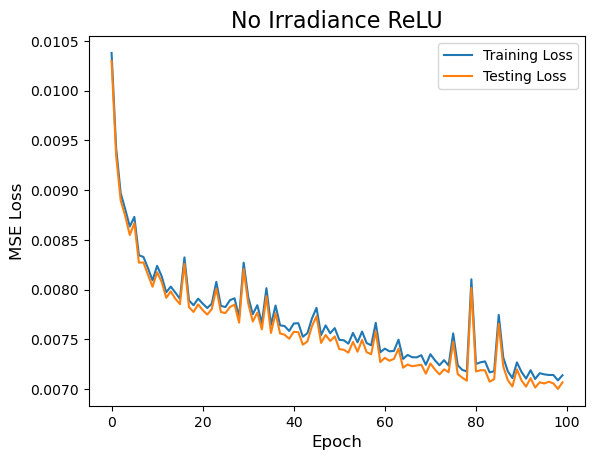

In [ ]:
tr_loss_no_irr = loss1[:,0]
te_loss_no_irr = loss1[:,1]
plt.plot(tr_loss_no_irr, label = 'Training Loss')
plt.plot(te_loss_no_irr, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('MSE Loss', fontsize = 12)
plt.title('No Irradiance ReLU', fontsize = 16)
plt.show()

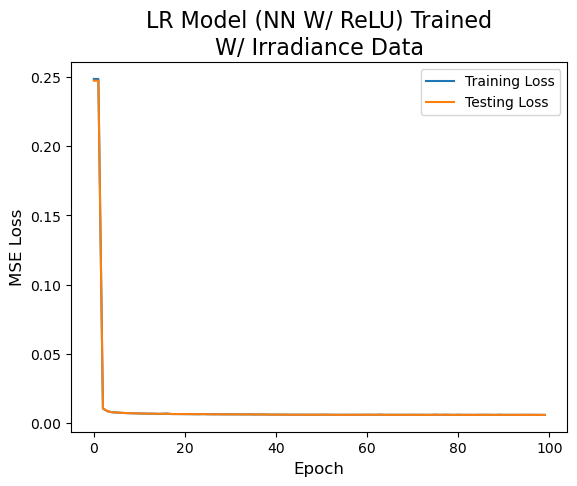

In [9]:
tr_loss_irr = loss2[:,0]
te_loss_irr = loss2[:,1]
plt.plot(tr_loss_irr, label = 'Training Loss')
plt.plot(te_loss_irr, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('MSE Loss', fontsize = 12)
plt.title('LR Model (NN W/ ReLU) Trained\nW/ Irradiance Data', fontsize = 16)
plt.show()

# tr_loss_no_irr = loss1[:,0]
# te_loss_no_irr = loss1[:,1]
# plt.plot(tr_loss_no_irr, label = 'Training Loss')
# plt.plot(te_loss_no_irr, label = 'Testing Loss')
# plt.legend()

# plt.show()

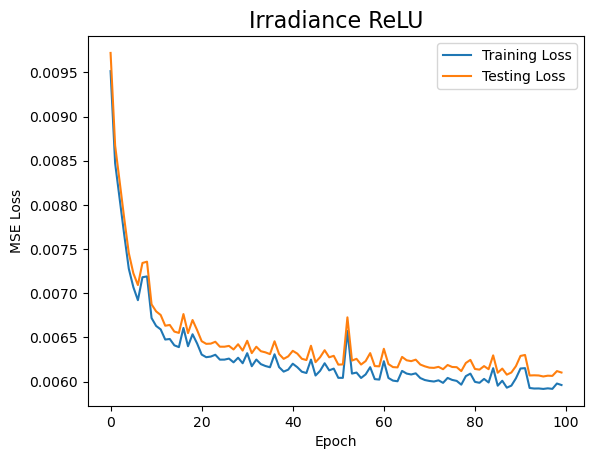

In [11]:
lm3 = LM(all_feats = True)
lm3.train(X_train_irr, y_train_irr, X_test_irr, y_test_irr, epochs = 100, verbose = False)
tr_loss, te_loss = lm3.loss()
plt.plot(tr_loss, label = 'Training Loss')
plt.plot(te_loss, label = 'Testing Loss')
plt.title("Irradiance ReLU", fontsize = 16)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [ ]:
# Prepare data
data_no_irr  = data.drop('irradiance', axis = 1)
y = data_no_irr['pvo']
X = data_no_irr.drop('pvo', axis = 1)
for col in X.columns:
    X[col] = (X[col] - X[col].mean()) / X[col].std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Convert to tensors
X_train = torch.tensor(X_train.values, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32)
X_test = torch.tensor(X_test.values, dtype = torch.float32)
y_test = torch.tensor(y_test.values, dtype = torch.float32)

# SGD Optimizer Trained Model

In [ ]:
model = LM()
model.train(X_train, y_train, X_test, y_test, epochs = 20)

Epoch: 1 | Loss: 0.011413038708269596
Epoch: 2 | Loss: 0.009677250869572163
Epoch: 3 | Loss: 0.004970866721123457
Epoch: 4 | Loss: 0.007968621328473091
Epoch: 5 | Loss: 0.01062751654535532
Epoch: 6 | Loss: 0.00809385534375906
Epoch: 7 | Loss: 0.014527124352753162
Epoch: 8 | Loss: 0.005665183532983065
Epoch: 9 | Loss: 0.0050316485576331615
Epoch: 10 | Loss: 0.007050896063446999
Epoch: 11 | Loss: 0.007046478800475597
Epoch: 12 | Loss: 0.0037645287811756134
Epoch: 13 | Loss: 0.0018107517389580607
Epoch: 14 | Loss: 0.002971428446471691
Epoch: 15 | Loss: 0.009151318110525608
Epoch: 16 | Loss: 0.00736206816509366
Epoch: 17 | Loss: 0.010476590134203434
Epoch: 18 | Loss: 0.0018460513092577457
Epoch: 19 | Loss: 0.004198592621833086
Epoch: 20 | Loss: 0.004552638158202171


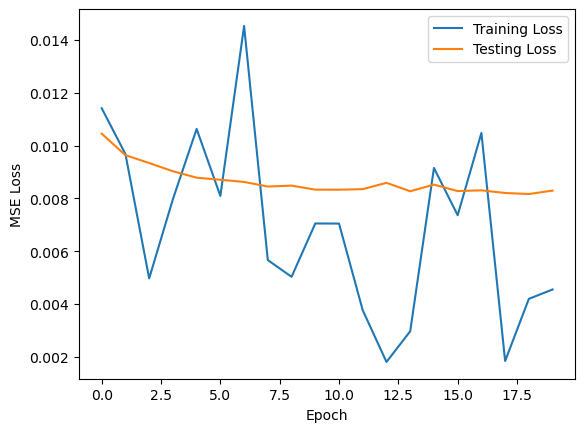

In [ ]:
tr_loss, te_loss = model.loss()
plt.plot(tr_loss, label = 'Training Loss')
plt.plot(te_loss, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [ ]:
device = model.device
mse_no_irr = ((model.predict(X_test.to(device))[:,0] - y_test.to(device))**2).mean()
print(f"Testing Data Loss (torch model - w/out irr.): {round(mse_no_irr.item(), 5)}")

Testing Data Loss (torch model - w/out irr.): 0.0083


### Replicating Procedure Above but Including Irradiance Feature

In [ ]:
# Prepare data
data_irr = data
y = data_irr['pvo']
X = data_irr.drop('pvo', axis = 1)
for col in X.columns:
    X[col] = (X[col] - X[col].mean()) / X[col].std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Convert to tensors
X_train = torch.tensor(X_train.values, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32)
X_test = torch.tensor(X_test.values, dtype = torch.float32)
y_test = torch.tensor(y_test.values, dtype = torch.float32)

model = LM(all_feats = True)
model.train(X_train, y_train, X_test, y_test, epochs = 20)

Epoch: 1 | Loss: 0.013702473603188992
Epoch: 2 | Loss: 0.0027249555569142103
Epoch: 3 | Loss: 0.009618253447115421
Epoch: 4 | Loss: 0.008160491473972797
Epoch: 5 | Loss: 0.005914721172302961
Epoch: 6 | Loss: 0.004640887025743723
Epoch: 7 | Loss: 0.004954288713634014
Epoch: 8 | Loss: 0.003156849881634116
Epoch: 9 | Loss: 0.003487358335405588
Epoch: 10 | Loss: 0.0018132585100829601
Epoch: 11 | Loss: 0.002363343723118305
Epoch: 12 | Loss: 0.0025544045493006706
Epoch: 13 | Loss: 0.0022866835352033377
Epoch: 14 | Loss: 0.0014149101916700602
Epoch: 15 | Loss: 0.0015817545354366302
Epoch: 16 | Loss: 0.0024500808212906122
Epoch: 17 | Loss: 0.0050765518099069595
Epoch: 18 | Loss: 0.0014930315082892776
Epoch: 19 | Loss: 0.006627303548157215
Epoch: 20 | Loss: 0.005952456500381231


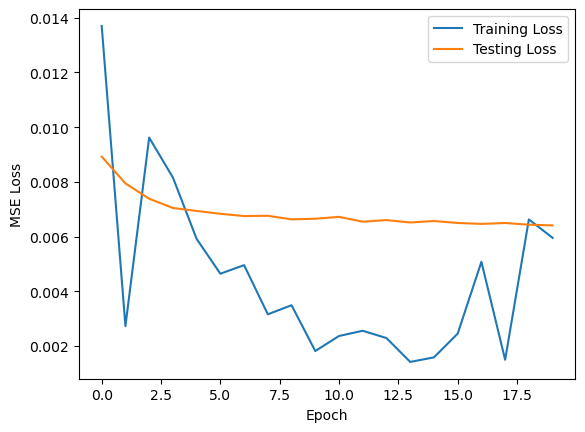

In [ ]:
tr_loss, te_loss = model.loss()
plt.plot(tr_loss, label = 'Training Loss')
plt.plot(te_loss, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [ ]:
device = model.device
mse_irr = ((model.predict(X_test.to(device))[:,0] - y_test.to(device))**2).mean()
print(f"Testing Data Loss (torch model - w/out irr.): {round(mse_no_irr.item(), 5)}")
print(f"Testing Data Loss (torch model - w/ irr.):    {round(mse_irr.item(), 5)}")

Testing Data Loss (torch model - w/out irr.): 0.0083
Testing Data Loss (torch model - w/ irr.):    0.00641


# Adam Optimizer Trained Model

/Users/colmcd/Desktop/S_25/CSCI 0451A/Final/solar-searcher/Notebooks/Models/models.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.loa

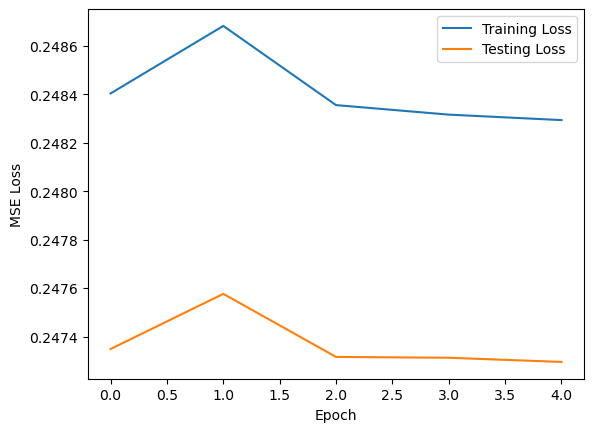

In [ ]:
if False:
    mod = LM()
    mod.loadModel('../../Data/model/LM1.pt.tar')
    loss = np.loadtxt('../../Data/model/loss_no_irr.txt')
    tr_loss = loss[:,0]
    te_loss = loss[:,1]
    plt.plot(tr_loss, label = 'Training Loss')
    plt.plot(te_loss, label = 'Testing Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.show()

# `sklearn` Linear Regression

# Adjusted Model Optimization

In [4]:
# Prepare data
data_no_irr  = data.drop('irradiance', axis = 1)
y = data_no_irr['pvo']
X = data_no_irr.drop('pvo', axis = 1)
for col in X.columns:
    X[col] = (X[col] - X[col].mean()) / X[col].std()
X_train_no_irr, X_test_no_irr, y_train_no_irr, y_test_no_irr = train_test_split(X, y, test_size = 0.3)
# Prepare data
data_irr  = data
y = data_irr['pvo']
X = data_irr.drop('pvo', axis = 1)
for col in X.columns:
    X[col] = (X[col] - X[col].mean()) / X[col].std()
X_train_irr, X_test_irr, y_train_irr, y_test_irr = train_test_split(X, y, test_size = 0.3)

# Convert to tensors
X_train_no_irr = torch.tensor(X_train_no_irr.values, dtype = torch.float32)
y_train_no_irr = torch.tensor(y_train_no_irr.values, dtype = torch.float32)
X_test_no_irr = torch.tensor(X_test_no_irr.values, dtype = torch.float32)
y_test_no_irr = torch.tensor(y_test_no_irr.values, dtype = torch.float32)

# Convert to tensors
X_train_irr = torch.tensor(X_train_irr.values, dtype = torch.float32)
y_train_irr = torch.tensor(y_train_irr.values, dtype = torch.float32)
X_test_irr = torch.tensor(X_test_irr.values, dtype = torch.float32)
y_test_irr = torch.tensor(y_test_irr.values, dtype = torch.float32)

# Initialize a models with no irradiance and with all features
# lm1 = LM()
# lm1.train(X_train_no_irr, y_train_no_irr, X_test_no_irr, y_test_no_irr, verbose = False, epochs = 20)
# lm2 = LM(all_feats = True)
# lm2.train(X_train_irr, y_train_irr, X_test_irr, y_test_irr, verbose = False, epochs = 20)

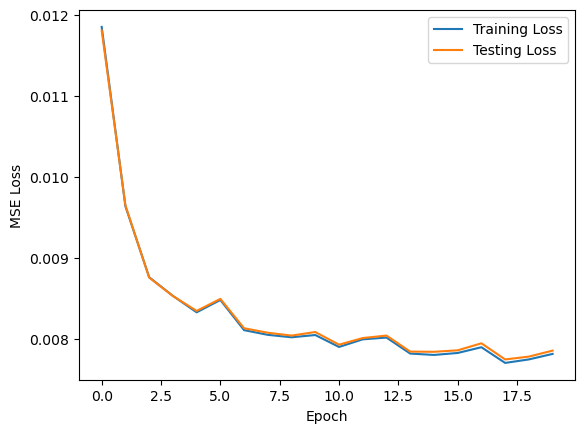

In [61]:
tr_loss, te_loss = lm1.loss()
plt.plot(tr_loss, label = 'Training Loss')
plt.plot(te_loss, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

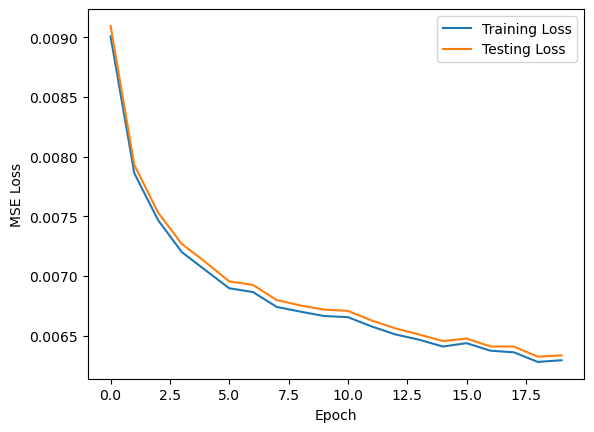

In [62]:
tr_loss, te_loss = lm2.loss()
plt.plot(tr_loss, label = 'Training Loss')
plt.plot(te_loss, label = 'Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()